# Formula 1 Cars image classification 

In [55]:
import os 
import pandas
import seaborn
import tensorflow as tf
import numpy
import random
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision
from shutil import copyfile
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import shutil

In [40]:
data_dir = "/Users/danielbustillo/Documents/Formula One Cars/"

uint8
(469, 750, 3)


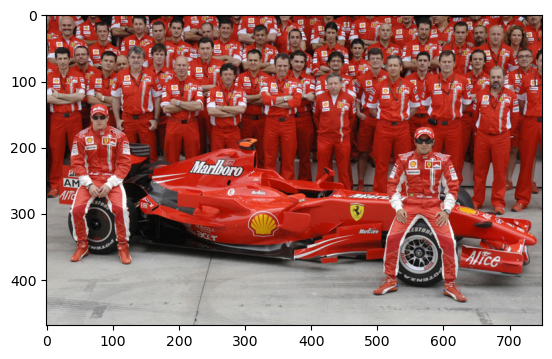

In [56]:

# load image as pixel array
data = image.imread(f'{data_dir}/Ferrari F1 car/00000022.jpg')
# summarize shape of the pixel array
print(data.dtype)
print(data.shape)
# display the array of pixels as an image
plt.imshow(data)
plt.show()

## Data cleaning

In [42]:
def find_files_with_different_extension(directory, target_extension):
    different_extension_files = []

    for foldername, subfolders, filenames in os.walk(directory):
        for filename in filenames:
            if filename == '.DS_Store':
                file_path = os.path.join(foldername, filename)
                os.remove(file_path)
                continue
            
            file_extension = os.path.splitext(filename)[1]
            if file_extension.lower() != target_extension.lower(): #what does this do?
                different_extension_files.append(os.path.join(foldername, filename))

    return different_extension_files


target_extension = '.jpg'

different_extension_files = find_files_with_different_extension(data_dir, target_extension)


if different_extension_files:
    print("Files with different extensions:")
    for file_path in different_extension_files:
        new_file_path = os.path.splitext(file_path)[0] + target_extension
        shutil.move(file_path, new_file_path)
        
    #do nothing

In [43]:
for foldername, subfolders, filenames in os.walk(data_dir):
    for filename in filenames:
        if filename == '.DS_Store':
            file_path = os.path.join(foldername, filename)
            os.remove(file_path)


## Splitting data set into test and train data


In [45]:
os.mkdir('./data')
os.mkdir('./data/train')
os.mkdir('./data/test')

In [46]:
for folder in os.listdir(data_dir):
    files=os.listdir(os.path.join(data_dir,folder))
    images=[]
    for f in files:
        try:
            img=Image.open(os.path.join(data_dir,folder,f))
            img=tf.io.read_file(os.path.join(data_dir,folder,f))
            img=tf.image.decode_image(img)
            if img.ndim == 3:
                images.append(f)
        except:
            pass
                      
    random.shuffle(images)
    count=len(images)
    split=int(0.7*count)
    os.mkdir(os.path.join('./data/train',folder))
    os.mkdir(os.path.join('./data/test',folder))

    for c in range(split):
        source_file=os.path.join(data_dir,folder,images[c])
        distination=os.path.join('./data/train',folder,images[c])
        copyfile(source_file,distination)
    for c in range(split,count):
        source_file=os.path.join(data_dir,folder,images[c])
        distination=os.path.join('./data/test',folder,images[c])
        copyfile(source_file,distination)   

2024-01-17 16:57:51.183469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-01-17 16:58:15.640725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-01-17 16:58:17.323983: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-01-17 16:58:17.598381: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


In [47]:
'''from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,  # Normalize pixel values to [0, 1]
    rotation_range=20,   # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,  # Randomly shift the width of the image by up to 20%
    height_shift_range=0.2,  # Randomly shift the height of the image by up to 20%
    shear_range=0.2,   # Shear the image by up to 20%
    zoom_range=0.2,    # Zoom in by up to 20%
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'  # Fill in empty pixels using the nearest available pixel
)
'''


In [48]:
'''batch_size = 32
image_size = (224, 224)  # You can adjust the image size as needed

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',  
    shuffle=True  # Shuffle the order of images
)
'''


Found 2486 images belonging to 8 classes.


In [52]:
IMAGE_SIZE=(224,224)
train_dir='./data/train'
test_dir='./data/test'

train_data=tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    image_size=IMAGE_SIZE
)
test_data=tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    image_size=IMAGE_SIZE,
    shuffle=False
)

class_names=train_data.class_names

# prefetching the datasets for faster training
train_data=train_data.prefetch(tf.data.AUTOTUNE)
test_data=test_data.prefetch(tf.data.AUTOTUNE)

Found 1572 files belonging to 8 classes.
Found 678 files belonging to 8 classes.


In [57]:
def plot_random_image(target_dir):
    """
    takes the directory as input and prints 5 random images from the randomly choosen class.
    """
    target_class=random.choice(os.listdir(target_dir))
    target_folder=os.path.join(target_dir,target_class)
    random_image=random.sample(os.listdir(target_folder),6)
    plt.figure(figsize=(20,5))
    for i in range(6):
        
        plt.subplot(1,6,i+1)
        img=tf.io.read_file(os.path.join(target_folder,random_image[i]))
        img=tf.io.decode_image(img)
        img=tf.image.resize(img,(224,244))
        plt.imshow(img/255.0)
        plt.title(f'{target_class}\n{img.shape}',size=20)
        plt.xticks([]);
        plt.yticks([])
        plt.tight_layout()
    plt.show()


/var/folders/c1/t5fkfr595z347dnt3qpgv4qm0000gn/T/ipykernel_45593/2408108861.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


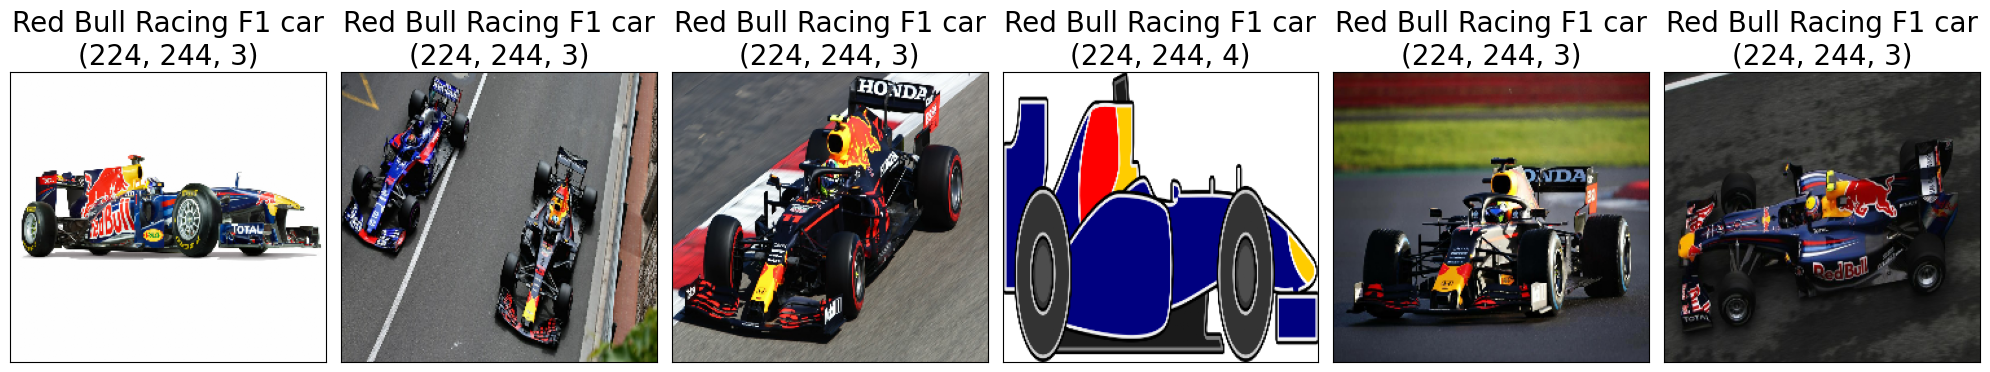

In [62]:
plot_random_image(train_dir)

In [63]:
# Train the model 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

num_classes = 8 # we are classifying each brand of car

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax') )


In [64]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [65]:
epochs = 10  # Adjust the number of epochs as needed
history = model.fit(train_data, epochs=epochs, validation_data=test_data)


Epoch 1/10


2024-01-17 17:21:35.513658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1572]
	 [[{{node Placeholder/_4}}]]
2024-01-17 17:21:35.513925: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1572]
	 [[{{node Placeholder/_0}}]]


 2/50 [>.............................] - ETA: 25s - loss: 716.7636 - accuracy: 0.2031

2024-01-17 17:21:38.789625: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 4/50 [=>............................] - ETA: 24s - loss: 622.5953 - accuracy: 0.1172

2024-01-17 17:21:40.145252: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


27/50 [===============>..............] - ETA: 11s - loss: 100.9198 - accuracy: 0.1215

2024-01-17 17:21:51.704850: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


50/50 [==============================] - ETA: 0s - loss: 56.4031 - accuracy: 0.1368

2024-01-17 17:22:02.162584: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [678]
	 [[{{node Placeholder/_0}}]]
2024-01-17 17:22:02.162821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [678]
	 [[{{node Placeholder/_4}}]]


50/50 [==============================] - 33s 609ms/step - loss: 56.4031 - accuracy: 0.1368 - val_loss: 2.0685 - val_accuracy: 0.1726
Epoch 2/10
 2/50 [>.............................] - ETA: 25s - loss: 2.0752 - accuracy: 0.2188 

2024-01-17 17:22:11.020773: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 4/50 [=>............................] - ETA: 23s - loss: 2.0722 - accuracy: 0.1875

2024-01-17 17:22:12.316219: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


27/50 [===============>..............] - ETA: 11s - loss: 1.9753 - accuracy: 0.2558

2024-01-17 17:22:23.786974: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


50/50 [==============================] - 33s 625ms/step - loss: 1.9291 - accuracy: 0.2786 - val_loss: 2.1145 - val_accuracy: 0.1785
Epoch 3/10
 2/50 [>.............................] - ETA: 27s - loss: 2.1235 - accuracy: 0.2031 

2024-01-17 17:22:44.355664: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 4/50 [=>............................] - ETA: 25s - loss: 2.0802 - accuracy: 0.2031

2024-01-17 17:22:45.742520: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


27/50 [===============>..............] - ETA: 12s - loss: 1.8793 - accuracy: 0.3067

2024-01-17 17:22:57.523186: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


50/50 [==============================] - 35s 658ms/step - loss: 1.7614 - accuracy: 0.3696 - val_loss: 2.2006 - val_accuracy: 0.1962
Epoch 4/10
 2/50 [>.............................] - ETA: 23s - loss: 1.6064 - accuracy: 0.4062 

2024-01-17 17:23:18.892150: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 5/50 [==>...........................] - ETA: 23s - loss: 1.5527 - accuracy: 0.5000

2024-01-17 17:23:20.274834: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


27/50 [===============>..............] - ETA: 12s - loss: 1.4037 - accuracy: 0.5046

2024-01-17 17:23:31.963848: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


50/50 [==============================] - 33s 625ms/step - loss: 1.3041 - accuracy: 0.5382 - val_loss: 2.4893 - val_accuracy: 0.1873
Epoch 5/10
 2/50 [>.............................] - ETA: 26s - loss: 1.4344 - accuracy: 0.5000 

2024-01-17 17:23:51.810453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 4/50 [=>............................] - ETA: 27s - loss: 1.2563 - accuracy: 0.5391

2024-01-17 17:23:53.398672: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


27/50 [===============>..............] - ETA: 12s - loss: 1.1342 - accuracy: 0.6308

2024-01-17 17:24:05.279512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


50/50 [==============================] - 34s 652ms/step - loss: 0.9884 - accuracy: 0.6692 - val_loss: 2.9229 - val_accuracy: 0.2006
Epoch 6/10
 2/50 [>.............................] - ETA: 27s - loss: 0.8548 - accuracy: 0.7344 

2024-01-17 17:24:26.324529: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 4/50 [=>............................] - ETA: 25s - loss: 0.8188 - accuracy: 0.7422

2024-01-17 17:24:27.714646: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


27/50 [===============>..............] - ETA: 12s - loss: 0.8453 - accuracy: 0.7454

2024-01-17 17:24:40.228460: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


50/50 [==============================] - 34s 645ms/step - loss: 0.8097 - accuracy: 0.7615 - val_loss: 2.9816 - val_accuracy: 0.1991
Epoch 7/10
 2/50 [>.............................] - ETA: 24s - loss: 0.6130 - accuracy: 0.8281 

2024-01-17 17:25:00.165815: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 4/50 [=>............................] - ETA: 23s - loss: 0.6460 - accuracy: 0.8047

2024-01-17 17:25:01.540794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


27/50 [===============>..............] - ETA: 12s - loss: 0.6988 - accuracy: 0.7731

2024-01-17 17:25:13.683837: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


50/50 [==============================] - 33s 634ms/step - loss: 0.6643 - accuracy: 0.7913 - val_loss: 3.4970 - val_accuracy: 0.2212
Epoch 8/10
 2/50 [>.............................] - ETA: 24s - loss: 0.5554 - accuracy: 0.7969 

2024-01-17 17:25:33.501081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 5/50 [==>...........................] - ETA: 23s - loss: 0.4552 - accuracy: 0.8313

2024-01-17 17:25:34.870097: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


27/50 [===============>..............] - ETA: 11s - loss: 0.4772 - accuracy: 0.8553

2024-01-17 17:25:46.287012: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


50/50 [==============================] - 32s 604ms/step - loss: 0.4587 - accuracy: 0.8594 - val_loss: 4.1858 - val_accuracy: 0.2257
Epoch 9/10
 2/50 [>.............................] - ETA: 24s - loss: 1.2334 - accuracy: 0.8750 

2024-01-17 17:26:05.372652: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 4/50 [=>............................] - ETA: 23s - loss: 0.7735 - accuracy: 0.8906

2024-01-17 17:26:06.734705: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


27/50 [===============>..............] - ETA: 11s - loss: 0.4522 - accuracy: 0.8854

2024-01-17 17:26:18.079813: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


50/50 [==============================] - 32s 609ms/step - loss: 0.4542 - accuracy: 0.8785 - val_loss: 4.0509 - val_accuracy: 0.2065
Epoch 10/10
 2/50 [>.............................] - ETA: 25s - loss: 0.2430 - accuracy: 0.9375 

2024-01-17 17:26:37.718163: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 4/50 [=>............................] - ETA: 24s - loss: 0.5322 - accuracy: 0.8906

2024-01-17 17:26:39.134400: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


27/50 [===============>..............] - ETA: 12s - loss: 0.4142 - accuracy: 0.8924

2024-01-17 17:26:50.916032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


50/50 [==============================] - 33s 625ms/step - loss: 0.4458 - accuracy: 0.8982 - val_loss: 3.8140 - val_accuracy: 0.2035


In [66]:
test_loss,test_acc=model.evaluate(test_data)

22/22 [==============================] - 6s 254ms/step - loss: 3.8140 - accuracy: 0.2035


In [67]:
def plot_loss_curves(history):
    
    '''
      returns seperate loss curves for training and validation metrics
    '''
    train_loss=history.history['loss']
    val_loss=history.history['val_loss']

    train_accuracy=history.history['accuracy']
    val_accuracy=history.history['val_accuracy']

    epochs=range(1,len(history.history['loss'])+1)
    plt.figure(figsize=(20,7))
  # plot loss data
    plt.subplot(1,2,1)
    plt.plot(epochs,train_loss,label="training_loss")
    plt.plot(epochs,val_loss,label="validation_loss")
    plt.title("Loss curves",size=20)
    plt.xlabel('epochs',size=20)
    plt.ylabel('loss',size=20)
    plt.legend(fontsize=15);
  # plt.show()

  # plot accuracy data
    plt.subplot(1,2,2)
    plt.plot(epochs,train_accuracy,label="training_acc")
    plt.plot(epochs,val_accuracy,label="validation_acc")
    plt.title("Accuracy curves",size=20)
    plt.xlabel('epochs',size=20)
    plt.ylabel('Accuracy',size=20)
    plt.tight_layout()
    plt.legend(fontsize=15);

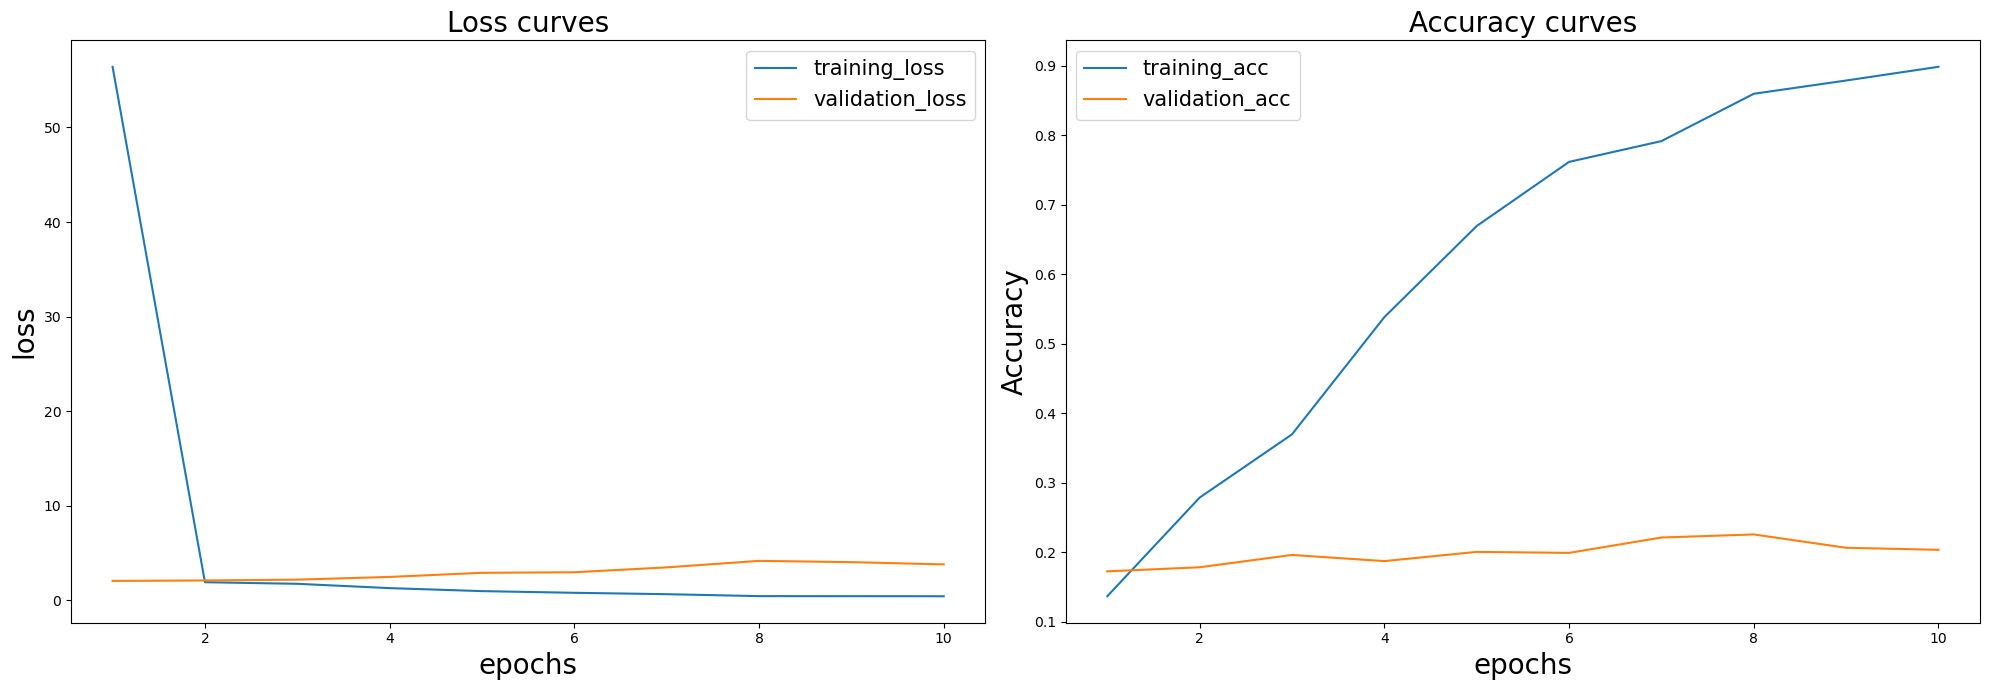

In [68]:
plot_loss_curves(history)

In [ ]:
#Predictions
